### Use this notebook to load a trained model and use the model to do post procesing data cleanup.

In [1]:
import os
import time
import json
import h5py
import threading
from collections import Counter
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from skimage.io import imread
from sklearn.model_selection import train_test_split
from skimage.segmentation import find_boundaries
from skimage.morphology import binary_opening, disk
from skimage.transform import resize
from scipy import ndimage as ndi

from IPython.display import SVG
import tensorflow as tf
import keras.backend as K
from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import model_to_dot
from keras.utils import Sequence
from keras.models import load_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Cropping2D
from keras.layers import MaxPooling2D
from keras.layers import UpSampling2D
from keras.layers import ZeroPadding2D
from keras.layers import GaussianNoise
from keras.layers import Conv2DTranspose
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import AvgPool2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import concatenate

from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import Iterator

from utils import get_datetime_now
from utils import reversed_recombined_holt_winters
from utils import rle_encode
from utils import rle_decode
from utils import multi_rle_encode
from utils import masks_as_image
from utils import get_mask_weights

_EPSILON = K.epsilon()

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16
BIGGEST_SIZE = 20
plt.rc('font', size=BIGGEST_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=BIGGEST_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=BIGGEST_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGEST_SIZE)  # fontsize of the figure title

Using TensorFlow backend.


In [2]:
dir_ext = ''
# Dict for saving all configuration data.
BASE_MODEL = "2018_1111_0234_48_GCN_scSE_256_bcedice_deconv"
NORMALIZE_INPUT_BATCH = True
GAUSSIAN_NOISE = None
DROPOUT = 0
LEARN_RATE = 1e-3
LOSS_FUNCTION = "bce_soft_dice_loss"
# LOSS_FUNCTION = "focal_soft_dice_loss"
LOSS_FUNCTION_KWARGS = {}#"gamma": 2.0, "alpha": 0.25}
MASK_METHOD = "fullmasks"
IMG_SIZE = 384  # 768, 384, 192, 96
CROP_SIZE = 384  # 512, 256, 128, 64
EDGE_CROP = (IMG_SIZE - CROP_SIZE) // 8
BATCH_SIZE = 8
# INPUT_SHAPE = (CROP_SIZE, CROP_SIZE, 3)
INPUT_SHAPE = (None, None, 3)
# INPUT_SHAPE = (221, 221, 3)
# number of training images to use (-1 == use all)
TRAIN_IMG_COUNT = -1
# number of validation images to use (-1 == use all)
VALID_IMG_COUNT = -1
data_config = {
    'base_model': BASE_MODEL,
    'normalize_input_batch': NORMALIZE_INPUT_BATCH,
    'gaussian_noise': GAUSSIAN_NOISE,
    'dropout': DROPOUT,
    'learn_rate': LEARN_RATE,
    'loss_function': LOSS_FUNCTION,
    'loss_function_kwargs': LOSS_FUNCTION_KWARGS,
    'mask_method': MASK_METHOD,
    'img_size': IMG_SIZE,
    'crop_size': CROP_SIZE,
    'edge_crop': EDGE_CROP,
    'batch_size': BATCH_SIZE,
    'input_shape': INPUT_SHAPE,
    'train_img_count': TRAIN_IMG_COUNT,
    'valid_img_count': VALID_IMG_COUNT,
}

In [3]:
from skimage.util import montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
# montage_rgb = lambda x: np.stack([montage(x[:, :, :, i], padding_width=10, fill=[255, 255, 255]) for i in range(x.shape[3])], -1)
montage_pad = lambda x, *args, **kwargs: montage(x, padding_width=10, *args, **kwargs)
ship_dir = "/media/Borg_LS/DATA/geos/airbus/input/"
train_img_path = os.path.join(ship_dir, f'train_{IMG_SIZE}')
train_seg_file = os.path.join(ship_dir, f"{MASK_METHOD}_{IMG_SIZE}.h5")
train_meta_filebase = f"{MASK_METHOD}_{IMG_SIZE}"
# train_meta_filebase = f"{MASK_METHOD}_768_down_{IMG_SIZE}"
# train_meta_filebase = "background_stats"
train_meta_file = os.path.join(ship_dir, train_meta_filebase + '.csv')
datetime_now = get_datetime_now()
run_name = f"{datetime_now}_{dir_ext}"
out_dir = f"out/{run_name}/"

# image_weights = pd.read_csv(background_stats_file)
train_df = pd.read_csv(train_meta_file)
print(train_meta_filebase + '.csv')
print(train_df.shape[0], 'records found')
print(train_df['ImageId'].value_counts().shape[0])
train_df.head()

fullmasks_384.csv
7323 records found
7323


counts          ImageId      b_mean      g_mean      r_mean      b_std  \
0       1  000155de5_1.jpg  104.061035   89.215230   62.870884   9.323625   
1       2  0005d01c8_2.jpg   42.364651   35.910577    2.008131   8.779849   
2       1  0006c52e8_1.jpg   37.227295   34.840637   26.054416  27.844679   
3       1  000e6378b_1.jpg  152.516561  157.396077  147.647990  14.867944   
4       1  001234638_1.jpg   55.594577   40.956380    5.009806  11.223013   

       g_std      r_std  x_min  x_max  y_min  y_max  height  width   area  \
0   9.007742   9.540237    141    244    175    210      36    104   3744   
1  10.029371  12.429706    153    232    158    226      69     80   5520   
2  30.694356  32.740875     84    300     55    329     275    217  59675   
3  14.824014  14.663811    176    208    182    202      21     33    693   
4  13.813567  18.563902    114    270    128    256     129    157  20253   

   n_pixels  ship_length  pixel_weight  ClusterId     brier  
0      3388          110      5.858968         32  0.003136  
1      1994          105      3.448283          5  0.003230  
2     13893          350     24.025574         12  0.009025  
3       360           39      0.622559         60  0.012135  
4      5739          203      9.924622         73  0.010037

# We make a generator to produce batches of images

In [4]:
# from utils import fbeta

class DataGenerator(Sequence):
    """Generates data for Keras"""
    def __init__(self,
                 img_df,
                 img_dir,
                 seg_file,
                 img_size=768,
                 crop_size=None,
                 edge_crop=None,
                 batch_size=4,
                 n_channels=3,
                 n_classes=1,
                 n_samples=-1,
                 use_weights=True,
                 shuffle=True,
                 ig_args=None,
                 dg_args=None,
                 seed=None
                 ):

        """Initialization"""
#         from utils import fbeta
#         from utils import focal_soft_dice_loss_wrapper
#         self.weight_func = focal_soft_dice_loss_wrapper(focal_coef=0.2, axis=None)
#         from utils import soft_dice_loss
#         self.weight_func = soft_dice_loss
#         from utils import focal_loss_wrapper
#         self.weight_func = focal_loss_wrapper(axis=None)
#         from utils import f2score
#         self.weight_func = f2score
#         self.weight_func = mean_fscore
#         self.weight_func = lambda x, y: np.sum((x - y)**2, axis=(1, 2, 3)) / np.prod(x.shape[1:])  # briar loss
        self.weight_func = lambda x, y: np.sum((x - y)**2) / np.prod(x.shape)  # briar loss
        self.lock = threading.Lock()
        
        if 'ImageId0' in img_df:
            self.img0_ids = img_df['ImageId0'].values
            
        self.img_ids = img_df['ImageId'].values
        self.n_records = len(self.img_ids)
        if isinstance(img_size, tuple):
            assert img_size[0] == img_size[1]
            self.img_size = img_size[0]
        else:
            self.img_size = img_size
            
        if crop_size is None:
            crop_size = img_size
        if isinstance(crop_size, tuple):
            assert crop_size[0] == crop_size[1]
            self.crop_size = crop_size[0]
        else:
            self.crop_size = crop_size
            
        assert self.crop_size <= self.img_size
        
        if edge_crop is None:
            self.edge_crop = (self.img_size - self.crop_size) // 8
            
        self.counts = img_df['counts'].values
        self.all_counts = np.sum(img_df['counts'].values)
        self.norm_counts = img_df['counts'].values / self.all_counts
        
#         self.pixels = img_df['n_pixels'].values
#         self.all_pixels = np.sum(img_df['n_pixels'].values)
#         self.norm_pixels = img_df['n_pixels'].values / self.all_pixels
        
        if 'weight' in img_df:
            self.img_weights = img_df['weight'].values
            self.all_weight = np.sum(self.img_weights)
            self.norm_weights = self.img_weights / self.all_weight
        else: 
            self.use_weights = False

        self.norm_weights = np.ones(self.n_records)
        self.loss_weights = np.ones(self.n_records)
        self.use_weights = use_weights
        
        self.img_dir = img_dir
        self.seg_file = seg_file
        self.shuffle = shuffle
        self.n_channels = n_channels
        self.n_classes = n_classes

        self._n_samples = self.n_records if n_samples in (None, -1) else min(n_samples, self.n_records)
        self._batch_size = self._n_samples if batch_size in (None, -1) else min(batch_size, self._n_samples)

        self.access_counter = Counter()
#         self.epochs_seen = 0
#         self.images_seen = 0
#         self.weight_gain = 0
#         self.ships_seen = 0

        self.augment = True
        if dg_args is not None and ig_args is None:
            self.image_gen = ImageDataGenerator(**dg_args)
            self.label_gen = ImageDataGenerator(**dg_args)
        elif dg_args is None and ig_args is not None: # Validation
            self.image_gen = ImageDataGenerator(**ig_args)
            self.label_gen = ImageDataGenerator()
        elif dg_args is not None and ig_args is not None:
            ig_args = dict(**ig_args, **dg_args)
            self.image_gen = ImageDataGenerator(**ig_args)
            self.label_gen = ImageDataGenerator(**dg_args)
        else:
            self.augment = False  # to get x_train_mean
        
        np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
        self.on_epoch_end()

#     @property
#     def ships_score(self):
#         return self.ships_seen / self.epochs_seen / self.sample_fraction
    
#     @property
#     def weight_score(self):
#         return self.weight_gain / self.epochs_seen / self.sample_fraction
    
    @property
    def n_samples(self):
        return self._n_samples
            
    @n_samples.setter
    def n_samples(self, n_samples):
        self._n_samples = self.n_records if n_samples in (None, -1) else min(n_samples, self.n_records)
        self._batch_size = min(self._batch_size, self._n_samples)
        
    @property
    def sample_fraction(self):
        self.n_samples / self.n_records
        
    @property
    def batch_size(self):
        return self._batch_size
    
    @batch_size.setter
    def batch_size(self, batch_size):
        self._batch_size = self.n_samples if batch_size in (None, -1) else min(batch_size, self.n_samples)
        
    def update_record_weights(self, y_true, y_hat):
#         y_pred = (y_hat >= 0.5) * 1
        
#         sample_losses = self.weight_func(y_true, y_hat)
#         self.loss_weights[self.current_index_array] = sample_losses
        
        for i, idx in enumerate(self.current_index_array):
            # The score for each individual sample in current_index_array.
            
            # subtract weight_func from 1 if weight_func is a metric (e.g. acc, IOU, Fbeta, etc.)
#             sample_scores = self.weight_func(y_true[i], y_pred[i])
#             sample_losses = 1 - sample_scores

            sample_losses = self.weight_func(y_true[i], y_hat[i])
    
            self.loss_weights[idx] = sample_losses
#             self.access_counter[idx] += 1

        # Setting index_array to None reminds us that we must call update_record_weights before on_epoch_end.
#         self.index_array = None
#         self.on_epoch_end()

    def print_weight_summary(self):
        for idx in range(self.n_records):
            if idx in self.index_array:
                print(f"{idx:>3} {self.access_counter[idx]:>3} {self.loss_weights[idx]:>.3f} {self.norm_weights[idx]:>.3f} index_array")
            else:
                print(f"{idx:>3} {self.access_counter[idx]:>3} {self.loss_weights[idx]:>.3f} {self.norm_weights[idx]:>.3f}")
            
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return (self.n_samples + self.batch_size - 1) // self.batch_size  # round up
#         return self.n_samples // self.batch_size

    def __getitem__(self, idx):
        """Generate one batch of data"""
        # Generate indexes of the batch
        self.current_index_array = self.index_array[self.batch_size * idx: self.batch_size * (idx + 1)]
        # Generate and return batch
        return self._get_batches_of_transformed_samples(self.current_index_array)

    def next(self):
        """For python 2.x.

        # Returns
            The next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array = next(self.index_generator)
        # The transformation of images is not under thread lock
        # so it can be done in parallel
        return self._get_batches_of_transformed_samples(index_array)

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.n_samples < self.n_records:
            if self.use_weights:
                self.norm_weights = self.loss_weights / np.sum(self.loss_weights)
                self.index_array = np.random.choice(self.n_records, self.n_samples, replace=False, p=self.norm_weights)
            else:
                self.index_array = np.random.choice(self.n_records, self.n_samples, replace=False, p=None)
        else:
            self.index_array = np.arange(self.n_records)
#         self.epochs_seen += 1
        if self.shuffle:
            np.random.shuffle(self.index_array)

    def get_next_batch(self, index_array):
        """Generates data containing batch_size samples"""
        x_batch = np.empty((len(index_array), self.img_size, self.img_size, self.n_channels), dtype=np.float32)
        y_batch = np.empty((len(index_array), self.img_size, self.img_size, self.n_classes), dtype=np.float32)
        with h5py.File(self.seg_file, 'r') as mask_1:
            for i, idx in enumerate(index_array):
                x_batch[i] = cv2.cvtColor(cv2.imread(os.path.join(self.img_dir, self.img_ids[idx])), cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
                try:
                    y_batch[i] = mask_1[self.img_ids[idx]][:] * 1
                except KeyError:
                    y_batch[i] = np.zeros((self.img_size, self.img_size, self.n_classes), dtype=np.float32)
        return x_batch, y_batch
    
    def augment_batch(self, x_batch, y_batch):
        seed = np.random.choice(range(9999))
        x_batch_aug = self.image_gen.flow(x_batch, batch_size=self.batch_size, seed=seed, shuffle=False).next()
        y_batch_aug = self.label_gen.flow(y_batch, batch_size=self.batch_size, seed=seed, shuffle=False).next()
        return x_batch_aug, (y_batch_aug > 0.5) * 1.0 # make sure mask is still zeros and ones.
    
    def crop_batch(self, x_batch_aug, y_batch_aug):
        x_batch_aug_crops = np.empty((self.batch_size, self.crop_size, self.crop_size, self.n_channels), dtype=np.float32)
        y_batch_aug_crops = np.empty((self.batch_size, self.crop_size, self.crop_size, self.n_classes), dtype=np.float32)
        for i in range(self.batch_size):
            x = np.random.randint(self.edge_crop, self.img_size - self.crop_size - self.edge_crop + 1)
            y = np.random.randint(self.edge_crop, self.img_size - self.crop_size - self.edge_crop + 1)
            x_batch_aug_crops[i] = x_batch_aug[i, y:(y + self.crop_size), x:(x + self.crop_size), :]
            y_batch_aug_crops[i] = y_batch_aug[i, y:(y + self.crop_size), x:(x + self.crop_size), :]
        return x_batch_aug_crops, y_batch_aug_crops
        
    def _get_batches_of_transformed_samples(self, index_array):
        
        # Create the raw batches
        x_batch, y_batch = self.get_next_batch(index_array)
        # Augment
        if self.augment:
            x_batch, y_batch = self.augment_batch(x_batch, y_batch)
        # Crop
        if self.crop_size < self.img_size:
            x_batch, y_batch = self.crop_batch(x_batch, y_batch)
        
        return x_batch, y_batch


In [7]:
def max_rotation(edge_crop=EDGE_CROP, img_size=IMG_SIZE, crop_size=CROP_SIZE):
    return np.arccos(np.sqrt((crop_size + 2 * edge_crop) / img_size)) * 180.0 / np.pi

In [5]:
# These args are applied to both training inputs and training outputs.
dg_args = dict(
#     height_shift_range = 32, # If random cropping, don't need to shift
#     width_shift_range = 32, # If random cropping, don't need to shift
#     shear_range = 0.01,
#     zoom_range = [0.9, 1.25], 
    horizontal_flip = True, 
    vertical_flip = True,
#     rotation_range = max_rotation(), 
    fill_mode = 'reflect',
    data_format = 'channels_last'
)

train_gen = DataGenerator(
    train_df, 
    train_img_path, 
    train_seg_file, 
    img_size=IMG_SIZE, 
    crop_size=CROP_SIZE,
    batch_size=TRAIN_IMG_COUNT, 
    n_samples=1024, 
    use_weights=True,
    shuffle=False,
    seed=777, 
#     dg_args=dg_args, 
    ig_args=None)


In [6]:
brier_loss = lambda x, y: np.mean(np.sum((x - y)**2, axis=-1))

In [7]:
def fbeta(y_true, y_pred, beta=2.0, axis=-1, smooth=1e-3):
    tp = K.sum(y_true * y_pred, axis=axis)
    fp = K.sum((1 - y_true) * y_pred, axis=axis)
    fn = K.sum(y_true * (1 - y_pred), axis=axis)
    return K.mean((beta**2 + 1) * tp / ((beta**2 + 1) * tp + beta**2 * fn + fp + smooth))

# CANT USE K.round IN LOSS FUNCTION. NOT DIFFERENTIABLE
def hard_dice_coef(y_true, y_pred, axis=-1, smooth=1e-3):
    return soft_dice_coef(K.round(y_true), K.round(y_pred), axis=axis, smooth=smooth)

def soft_dice_coef(y_true, y_pred, axis=-1, smooth=1e-3):
    AB = K.sum(y_true * y_pred, axis=axis)
    A = K.sum(y_true, axis=axis)
    B = K.sum(y_pred, axis=axis)
    return (2. * AB + smooth) / (A + B + smooth)

def soft_dice_loss(y_true, y_pred, axis=-1, smooth=1e-3):
    return 1 - soft_dice_coef(y_true, y_pred, axis=axis, smooth=smooth)

def bce_soft_dice_loss_wrapper(bce_weight=0.5):
    def bce_soft_dice_loss(y_true, y_pred):
        return binary_crossentropy(y_true, y_pred) * bce_weight + soft_dice_loss(y_true, y_pred, axis=-1) * (1 - bce_weight)
    return bce_soft_dice_loss

def focal_loss_wrapper(gamma=2., alpha=.25, axis=-1):
    def focal_loss(y_true, y_pred):
        y_pred_c = K.clip(y_pred, _EPSILON, 1.0 - _EPSILON)
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred_c, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred_c, tf.zeros_like(y_pred))
        res1 =      alpha  * K.pow(1. - pt_1, gamma) * K.log(     pt_1)
        res0 = (1 - alpha) * K.pow(     pt_0, gamma) * K.log(1. - pt_0)
        return -K.mean(res1 + res0, axis=axis)
    return focal_loss

def focal_soft_dice_loss_wrapper(gamma=2., alpha=.25, axis=-1):
    focal_loss = focal_loss_wrapper(gamma=gamma, alpha=alpha, axis=axis)
    def focal_soft_dice_loss(y_true, y_pred, axis=-1):
        return focal_loss(y_true, y_pred) * 0.8 + soft_dice_loss(y_true, y_pred, axis=axis) * 0.2
    return focal_soft_dice_loss

def brier_loss_keras(y_true, y_pred):
    return K.sum((y_pred - y_true)**2, axis=-1)

loss_functions = {
    "focal_loss": focal_loss_wrapper,
    "soft_dice_loss": soft_dice_loss,
    "bce_soft_dice_loss": bce_soft_dice_loss_wrapper,
    "focal_soft_dice_loss": focal_soft_dice_loss_wrapper
}

In [8]:
from utils import get_best_model_name
best_model_name = get_best_model_name(BASE_MODEL)
seg_model = load_model(best_model_name, compile=False)

out/2018_1111_0234_48_GCN_scSE_256_bcedice_deconv/ship_model.085-0.0124.hdf5


In [9]:
focal_loss = focal_loss_wrapper()
seg_model.compile(
    optimizer=Adam(lr=LEARN_RATE), 
#     loss=brier_loss_keras,
    loss=loss_functions[LOSS_FUNCTION](**LOSS_FUNCTION_KWARGS),
    metrics=[binary_crossentropy, focal_loss, brier_loss_keras])

In [10]:
n_samples_temp = train_gen.n_samples
print(len(train_gen), train_gen.n_samples, len(train_gen.index_array), train_gen.batch_size, n_samples_temp)
train_gen.n_samples = -1
print(len(train_gen), train_gen.n_samples, len(train_gen.index_array), train_gen.batch_size, n_samples_temp)
train_gen.on_epoch_end()
print(len(train_gen), train_gen.n_samples, len(train_gen.index_array), train_gen.batch_size, n_samples_temp)

for i in range(len(train_gen)):
    t0 = time.time()
    x_train, y_train = train_gen[i]
    t1 = time.time()
    y_hat = seg_model.predict(x_train, batch_size=BATCH_SIZE, verbose=1)
    t2 = time.time()
    train_gen.update_record_weights(y_train, y_hat)
    print(
        f"{t1 - t0:>.3f} {t2 - t1:>.3f} {time.time() - t2:>.3f}", 
        f"{np.min(train_gen.loss_weights):>9.5e} {np.max(train_gen.loss_weights):>9.5g}", 
        f"{np.mean(train_gen.loss_weights):>9.5f} {np.median(train_gen.loss_weights):>9.5g} {np.std(train_gen.loss_weights):>9.5f}"
    )
    
print(len(train_gen), train_gen.n_samples, len(train_gen.index_array), train_gen.batch_size, n_samples_temp)
train_gen.n_samples = n_samples_temp
print(len(train_gen), train_gen.n_samples, len(train_gen.index_array), train_gen.batch_size, n_samples_temp)
train_gen.on_epoch_end()
print(len(train_gen), train_gen.n_samples, len(train_gen.index_array), train_gen.batch_size, n_samples_temp)
loss_weight_indices = np.argsort(train_gen.loss_weights)

1 1024 1024 1024 1024
8 7323 1024 1024 1024
8 7323 7323 1024 1024
1024/1024 [==============================] - 24s 24ms/step
4.591 24.111 0.703 1.24545e-04         1   0.86096         1   0.34485
1024/1024 [==============================] - 22s 21ms/step
4.499 21.672 0.569 1.24545e-04         1   0.72191         1   0.44631
1024/1024 [==============================] - 22s 21ms/step
4.479 21.559 0.668 9.08391e-05         1   0.58300         1   0.49056
1024/1024 [==============================] - 21s 21ms/step
4.523 21.423 0.685 9.08391e-05         1   0.44400  0.012609   0.49354
1024/1024 [==============================] - 21s 21ms/step
4.669 21.561 0.725 9.08391e-05         1   0.30508 0.0064547   0.45588
1024/1024 [==============================] - 21s 21ms/step
4.594 21.519 0.605 9.08391e-05         1   0.16614 0.0046496   0.36535
1024/1024 [==============================] - 22s 21ms/step
4.948 21.563 0.636 9.08391e-05         1   0.02721  0.003725   0.14328
155/155 [===============

In [ ]:
for i, layer in enumerate(seg_model.layers):
    print(i+1, layer.name, layer.trainable)
    weights = layer.get_weights()
    for w in weights:
        print('  ', w.shape, w.min(), w.max())

In [11]:
train_loss_weights_old = train_df['brier'].values

In [12]:
print(np.sum(train_loss_weights_old), np.sum(train_gen.loss_weights), np.sum(train_gen.loss_weights - train_loss_weights_old))
len(np.where(train_loss_weights_old > train_gen.loss_weights)[0]) / len(train_loss_weights_old)

51.50855171720711 45.16764642203796 -6.34090529516915


0.5368018571623652

In [13]:
n_samples = 8
new_worst_idx = loss_weight_indices[-n_samples:][::-1]
new_worst_gen_loss = train_gen.loss_weights[new_worst_idx]
new_worst_gen_ids = train_gen.img_ids[new_worst_idx]
new_worst_df_loss = train_df['brier'].values[new_worst_idx]
new_worst_df_ids = train_df['ImageId'].values[new_worst_idx]
new_header = (' ' * len(new_worst_gen_ids[0]), 'new worst', 'prev loss', 'change')
print(f"{new_header[0]} {new_header[1]:>10} {new_header[2]:>10} {new_header[3]:>10}")
for wgl, wgi, wdl, wdi in zip(new_worst_gen_loss, new_worst_gen_ids, new_worst_df_loss, new_worst_df_ids):
    assert wgi == wdi
    print(f'{wgi} {wgl:<10.6g} {wdl:<10.6g} {wgl - wdl:<10.6g}')

                 new worst  prev loss     change
f53ac765d_2.jpg 0.184354   0.0727747  0.11158   
a182903f8_4.jpg 0.135626   0.0857075  0.0499182 
7d35cf46b_3.jpg 0.119656   0.039918   0.0797379 
a182903f8_5.jpg 0.0983094  0.0389246  0.0593848 
a182903f8_3.jpg 0.0981142  0.0436816  0.0544326 
a129c36b3_1.jpg 0.0931585  0.0446031  0.0485554 
2dcfb3880_1.jpg 0.0918331  0.0660875  0.0257456 
3a22cf69c_3.jpg 0.0908865  0.0453002  0.0455863 


In [14]:
old_loss_weight_indices = np.argsort(train_df['brier'].values)
old_worst_idx = old_loss_weight_indices[-8:][::-1]
old_worst_df_loss = train_df['brier'].values[old_worst_idx]
old_worst_df_ids = train_df['ImageId'].values[old_worst_idx]
old_worst_gen_loss = train_gen.loss_weights[old_worst_idx]
old_worst_gen_ids = train_gen.img_ids[old_worst_idx]
old_header = (' ' * len(old_worst_df_ids[0]), 'prev worst', 'new loss', 'change')
print(f"{old_header[0]} {old_header[1]:>10} {old_header[2]:>10} {old_header[3]:>10}")
for wdl, wdi, wgl, wgi in zip(old_worst_df_loss, old_worst_df_ids, old_worst_gen_loss, old_worst_gen_ids):
    assert wgi == wdi
    print(f'{wdi} {wdl:<10.6g} {wgl:<10.6g} {wgl - wdl:<10.6g}')

                prev worst   new loss     change
a182903f8_4.jpg 0.0857075  0.135626   0.0499182 
a8c26e4e4_1.jpg 0.0855015  0.00678465 -0.0787168
59bf84db8_2.jpg 0.0814117  0.00975401 -0.0716577
f94e65516_1.jpg 0.0804995  0.0122498  -0.0682497
59bf84db8_1.jpg 0.0782794  0.013465   -0.0648144
4a73910cc_2.jpg 0.077451   0.0400217  -0.0374293
442d13001_5.jpg 0.075103   0.00623477 -0.0688682
9c3e750e1_3.jpg 0.0741348  0.00923798 -0.0648968


1 int64 (384, 384, 1) 0.13562573989614635
1/1 [==============================] - 1s 873ms/step
1 int64 (384, 384, 1) 0.0067846498113147665
1/1 [==============================] - 0s 35ms/step
1 int64 (384, 384, 1) 0.0097540071090699
1/1 [==============================] - 0s 35ms/step
1 int64 (384, 384, 1) 0.012249814120783799
1/1 [==============================] - 0s 34ms/step
1 int64 (384, 384, 1) 0.013464990311739969
1/1 [==============================] - 0s 35ms/step
1 int64 (384, 384, 1) 0.04002169614579558
1/1 [==============================] - 0s 31ms/step
1 int64 (384, 384, 1) 0.006234772482209167
1/1 [==============================] - 0s 34ms/step
1 int64 (384, 384, 1) 0.009237984373761712
1/1 [==============================] - 0s 31ms/step


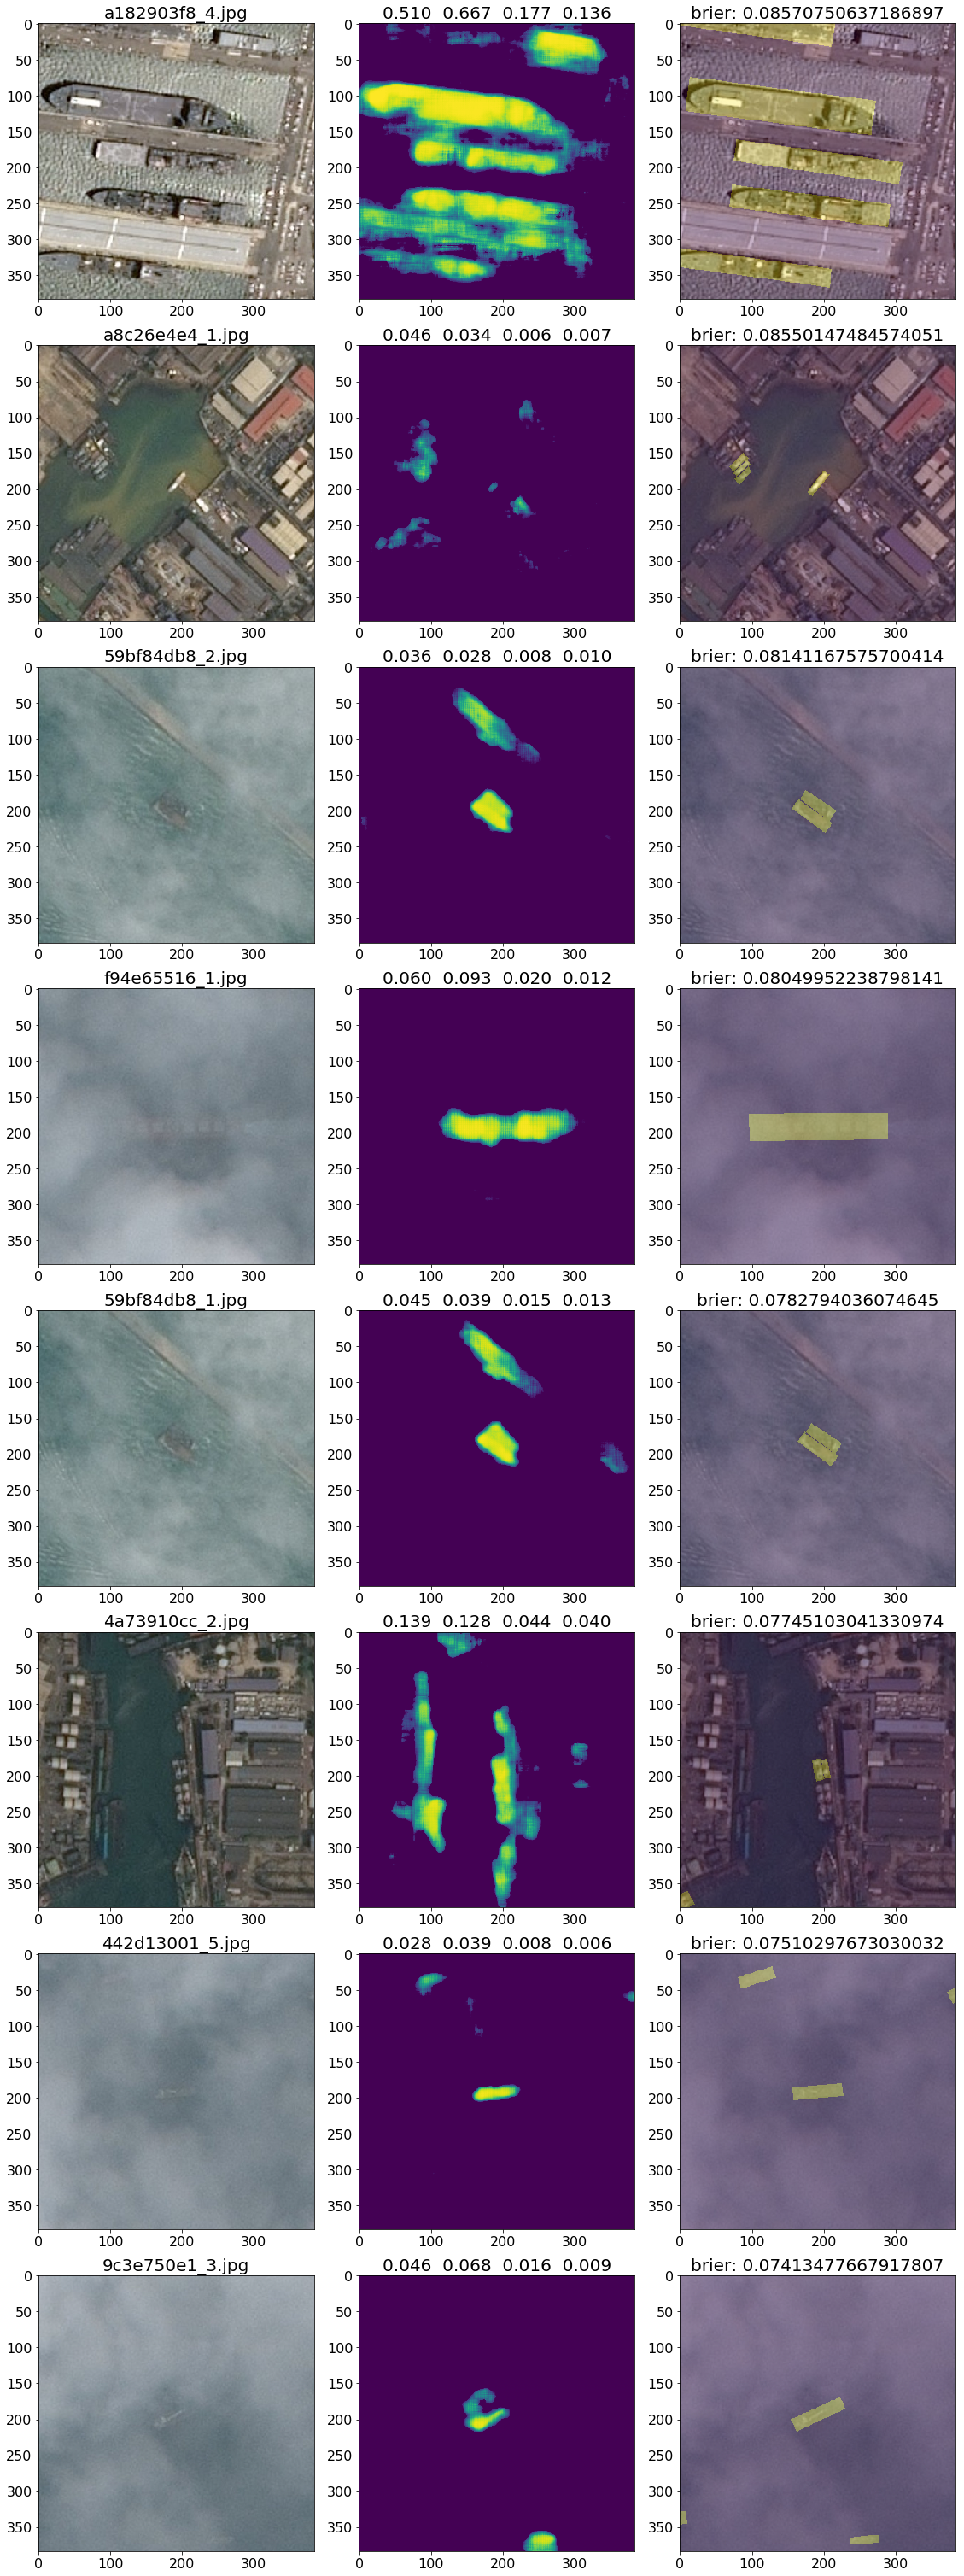

In [15]:
fig, m_axs = plt.subplots(n_samples, 3, figsize = (16, 42))
with h5py.File(train_seg_file, 'r') as mask_1:
    for (ax1, ax2, ax4), c_img_id, c_img_loss in zip(m_axs, old_worst_df_ids, old_worst_df_loss):
        c_file = os.path.join(train_img_path, c_img_id)
        c_img = cv2.cvtColor(cv2.imread(c_file), cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        c_seg = seg_model.predict(c_img[None, ...])
        cur_seg = binary_opening(c_seg[0] > 0.5, np.expand_dims(disk(2), -1))
        cur_rles = multi_rle_encode(cur_seg)
        try:
            y_true = mask_1[c_img_id][:] * 1
            print('1', y_true.dtype, y_true.shape, brier_loss(y_true, c_seg))
        except KeyError:
            y_true = np.zeros((IMG_SIZE, IMG_SIZE, 1), dtype=np.uint8)
            print('2', y_true.dtype, y_true.shape, brier_loss(y_true, c_seg))
        score = seg_model.evaluate(c_img[None, ...], y_true[None, ...])
        
        ax1.imshow(c_img)
        ax1.set_title(c_img_id)
        ax2.imshow(c_seg[0, :, :, 0], vmin = 0, vmax = 1)
        ax2.set_title('  '.join(map(lambda x: f"{x:.3f}", score)))
        ax4.imshow(c_img)
        ax4.imshow(y_true[..., -1], vmin = 0, vmax = 1, alpha=0.3)
        ax4.set_title(f'brier: {c_img_loss}')

plt.tight_layout()
fig.savefig(os.path.join('out', BASE_MODEL, f"{train_meta_filebase}_prev_worst_improved.jpg"))

In [16]:
gamma = 0.8
train_loss_weights_new = train_loss_weights_old * gamma + train_gen.loss_weights * (1 - gamma)
train_loss_weights_old[-3:], train_gen.loss_weights[-3:], train_loss_weights_new[-3:]

(array([0.0093781 , 0.00286995, 0.0019032 ]),
 array([0.01183333, 0.00333729, 0.0019533 ]),
 array([0.00986914, 0.00296341, 0.00191322]))

In [21]:
train_df['brier'] = train_loss_weights_new

In [12]:
train_df['brier'] = train_gen.loss_weights

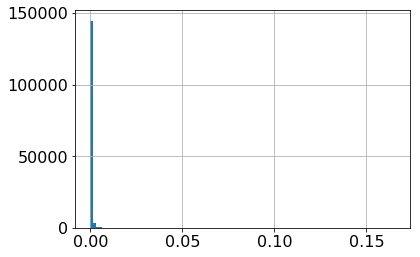

In [47]:
train_df['brier'].hist(bins=100);

In [125]:
fname = os.path.join(ship_dir, "background_stats.csv")
train_df = pd.read_csv(fname)
print(len(train_df))

149999


In [42]:
train_df.head()

counts        ImageId     r_mean      g_mean      b_mean      r_std  \
0       1  000155de5.jpg  62.996141   88.601006  103.075283   7.531754   
1       5  000194a2d.jpg  95.888536  119.585870  106.985365  39.648506   
2       2  0002756f7.jpg  80.322021  108.290554  101.470337  15.695324   
3       1  00053c6ba.jpg  59.194892   70.594415   76.423950  18.226488   
4       2  0005d01c8.jpg   1.688395   35.385993   42.161194   8.570045   

       g_std      b_std  n_pixels  pixel_weight  ClusterId     brier  
0   7.403473   7.339360       847      0.075790        149  0.000987  
1  24.411645  17.879594       356      0.049135         19  0.001707  
2  15.418210  15.434695        99      0.025911         72  0.000202  
3  18.412839  18.397975        41      0.016675         27  0.000171  
4   7.340686   6.063473      2004      0.116578         50  0.001435

In [43]:
train_df.tail()

counts        ImageId      r_mean      g_mean      b_mean      r_std  \
37433       1  fff67c31a.jpg  176.848748  182.279534  173.021790  18.276402   
37434       1  fff77c602.jpg    4.987230   45.061584   60.310710  10.261203   
37435       1  fff909871.jpg   52.542697  110.331021   96.633898   9.384522   
37436       1  fffcb6464.jpg    4.109009    9.388984   38.315972   7.656249   
37437       1  fffdd2377.jpg   88.610575  132.321025  122.500916  33.111437   

           g_std      b_std  n_pixels  pixel_weight  ClusterId     brier  
37433  18.118194  18.004078       102      0.026301          2  0.001448  
37434   8.382354   5.713230      4544      0.175545         77  0.003506  
37435   7.313668   7.047427        95      0.025382        101  0.000131  
37436   8.994238   8.095437       226      0.039149         14  0.000353  
37437  32.438571  32.344797      1076      0.085423        125  0.000906

In [119]:
img_ids_old = train_df['ImageId'].values
img_ids_new = np.array([img_id.replace('_768.jpg', '.jpg') for img_id in img_ids_old])
train_df['ImageId'] = pd.Series(img_ids_new, index=train_df.index)

In [47]:
train_df = train_df.drop(columns=['ImageId0'])

In [87]:
train_df.rename(columns={'ClusterId_100': 'ClusterId'}, inplace=True)

In [88]:
train_df.rename(columns={'r_mean': 'b_mean0'}, inplace=True)
train_df.rename(columns={'b_mean': 'r_mean'}, inplace=True)
train_df.rename(columns={'b_mean0': 'b_mean'}, inplace=True)

In [89]:
train_df.rename(columns={'r_std': 'b_std0'}, inplace=True)
train_df.rename(columns={'b_std': 'r_std'}, inplace=True)
train_df.rename(columns={'b_std0': 'b_std'}, inplace=True)

In [128]:
for col in ['r_mean', 'g_mean', 'b_mean']:
    val_old = train_df[col].values
    val_new = val_old * 255.0
    train_df[col] = pd.Series(val_new, index=train_df.index)

In [129]:
for col in ['r_std', 'g_std', 'b_std']:
    val_old = train_df[col].values
    val_new = val_old * 255.0
    train_df[col] = pd.Series(val_new, index=train_df.index)

In [49]:
# removed from fullmasks_192.csv
low_res = [
    '1a56132bc_1.jpg', 
    '1fcd09fdf_1.jpg', 
    '21ad7a98d_1.jpg', 
    '221d429af_1.jpg', 
    '27ded27a6_1.jpg', 
    '2cd9f6542_1.jpg', 
    '2d4a3ad9f_1.jpg', 
    '301d489d9_1.jpg', 
    '33e019433_1.jpg', 
    '3d7e3902d_1.jpg', 
    '3de5abd07_1.jpg', 
    '4c03a74fa_1.jpg',
    '42c90bbc2_1.jpg', 
    '45365ba8d_1.jpg', 
    '4eca93831_1.jpg', 
    '5c1f413c3_1.jpg', 
    '5cc0ed875_1.jpg', 
    '66de7e8d6_2.jpg', 
    '6c85bd549_1.jpg', 
    '7178a5302_1.jpg', 
    '7573b6fe0_1.jpg', 
    '95340daf5_1.jpg', 
    'a5be35c12_1.jpg', 
    'abefabc92_1.jpg', 
    'd19cce902_1.jpg', 
    'c15b6af5a_1.jpg', 
    'cb7499731_1.jpg', 
    'e8f8275fc_1.jpg', 
    'f0ce68058_1.jpg', 
    'f1832f81c_1.jpg', 
    'fed3a4375_1.jpg', 
]
missing_ships = ['a280fe312_1.jpg']

In [42]:
# removed from fullmasks_384_down_192.csv
low_res = [
    '67c6135dd_1_384.jpg',
    '27ded27a6_1_384.jpg',
    'f1832f81c_1_384.jpg',
    'dce9a2b8c_1_384.jpg']

bad_mask = ['cc9271ef5_1_384.jpg']

In [24]:
#bad_overlap
low_res = ['4bfc4cc05_1.jpg']

In [51]:
# removed from fullmasks_384.csv
low_res = [
    '01b030c4b_1.jpg', '1fcd09fdf_1.jpg', 
    '27ded27a6_1.jpg', '5bf23faa1_1.jpg',
    '5c1f413c3_1.jpg', '67c6135dd_1.jpg',
    '6c85bd549_1.jpg', '72ee20da7_1.jpg',
    '9a67345e4_1.jpg', 'ab6dd064f_1.jpg',
    'b7643cfd8_1.jpg', 'b60afd050_1.jpg',
    'b9c532adf_1.jpg', 'bf0820f3c_1.jpg',
    'c15b6af5a_1.jpg', 'c9fbdab2b_1.jpg',
    'cac0ef25b_1.jpg', 'cdea345ac_1.jpg',
    'd538b9285_1.jpg', 'dce9a2b8c_1.jpg', 
    'e8f8275fc_1.jpg', 'e99c164e4_1.jpg',
    'f0ce68058_1.jpg', 'f1832f81c_1.jpg',
    'fe5b2b445_1.jpg', 'fed3a4375_1.jpg',
]

In [48]:
missing_segs = [
    'c98adae25.jpg', 'ae3dc4f96.jpg', 'db6bd5497.jpg',
    '09c49fb3d.jpg', 'b98fadbe6.jpg', '261af847a.jpg',
    '1798f81c9.jpg', '9984793d9.jpg', '2d80cdcd2.jpg',
    '4bef9d21b.jpg', '2410e5ca2.jpg', 'd88bfdafc.jpg', 
    '738e99b63.jpg', '99ef3e71b.jpg', '731f504e5.jpg',
    'd5102732f.jpg', '919e341b8.jpg', '7160d01dc.jpg', 
    '1b4a6539a.jpg', '99248ac6e.jpg', 'f9e66a6fe.jpg', 
    'fdf018a2d.jpg', '8a7abc7a2.jpg', 'f331e6546.jpg', 
    '4d4a1f002.jpg', '3c814ab2e.jpg', 'c9fa3e0b1.jpg', 
    'f68a4249e.jpg', '4f02b2381.jpg', '9c15e2643.jpg',
    '9d2de1ba9.jpg', '88efbddbc.jpg', 'a9364256c.jpg',
    '0f30940aa.jpg', 'd6d090131.jpg', '8639577a6.jpg', 
    'abd0aa2e8.jpg', '266be9837.jpg', '84b35bd43.jpg',
    'cebe251ed.jpg', '2da5843a3.jpg', '2cc7799b4.jpg',
    'a87026497.jpg', '836e44cc8.jpg', '78376afae.jpg', 
    'cab1ddb95.jpg', 'ccb365fca.jpg', 'b0c2b7382.jpg',
    'ca75a6207.jpg', 'a6bd394af.jpg', '5cbb206f0.jpg', 
    'c02e5255f.jpg', 'db66e1593.jpg', '390542ac0.jpg', 
    '3ea817c2b.jpg', 'aab5f1a09.jpg', 'c6b1facda.jpg',
    '458bac358.jpg', '2085e17b0.jpg', '803fb0bdc.jpg', 
    'f4894e99c.jpg', '193f3a261.jpg', '6b7ff665a.jpg', 
    '25563581a.jpg', 'f74fba65a.jpg', 'b5e2b8d7d.jpg'
]

In [49]:
for cid in missing_segs:
    if cid in train_df['ImageId'].values:
        train_df = train_df[train_df['ImageId'] != cid]
    else:
        print(cid, f'not found. {cid}, (low_res)')

In [50]:
print(len(train_df))
train_df.head()

149916


counts        ImageId      r_mean      g_mean      b_mean      r_std  \
0       0  00003e153.jpg   27.138563   47.256076   75.224935   5.686547   
1       0  0001124c7.jpg  128.779297  144.029297  148.945964   4.640331   
2       0  0001b1832.jpg  112.428060  145.584310  148.589084   7.232260   
3       0  0002d0f32.jpg   41.374349   49.014106   59.794922  55.561713   
4       0  000303d4d.jpg   60.502713   65.363173   69.168728  19.923475   

       g_std      b_std  hist_0  red_0      ...       hist_1  red_1  green_1  \
0   5.068152   4.590628     125     28      ...          112     23       43   
1   4.208876   4.339877     112    127      ...          103    132      147   
2   6.483256   6.377679      93    112      ...           83    104      138   
3  54.141008  49.142723     164      8      ...           60     70       78   
4  19.921159  19.919724     120     60      ...           68     47       52   

   blue_1  hist_2  red_2  green_2  blue_2  ClusterId         brier  
0      72      17     41       59      84         10  1.399383e-06  
1     152      39    120      137     141          1  2.140532e-03  
2     141      77    120      152     155         48  1.893738e-08  
3      85      30    163      166     167         73  2.743826e-04  
4      56      66     73       78      82        126  1.649602e-04  

[5 rows x 22 columns]

In [16]:
train_df.tail()

ImageId  counts  ClusterId     brier
41983  fff77c602.jpg       1          0  0.003568
41984  fff909871.jpg       1          0  0.000081
41985  fffcb6464.jpg       1          0  0.000247
41986  fffd924fb.jpg       2          0  0.000163
41987  fffdd2377.jpg       1          0  0.000688

In [22]:
train_df.to_csv(train_meta_file, index=False)

In [36]:
train_df.describe(percentiles=[0.01, 0.05, .25, .5, .75, 0.95, 0.99])

counts  ClusterId         brier
count  41949.000000    41949.0  41949.000000
mean       1.897375        0.0      0.000976
std        1.866537        0.0      0.001400
min        1.000000        0.0      0.000012
1%         1.000000        0.0      0.000031
5%         1.000000        0.0      0.000063
25%        1.000000        0.0      0.000234
50%        1.000000        0.0      0.000574
75%        2.000000        0.0      0.001200
95%        6.000000        0.0      0.003085
99%       11.000000        0.0      0.006472
max       15.000000        0.0      0.051149

In [19]:
BATCH_SIZE = 64
BATCH_NUM = 5

best_left = BATCH_NUM*BATCH_SIZE
best_right = (BATCH_NUM+1)*BATCH_SIZE
print(best_left, best_right)
best_idx = loss_weight_indices[best_left:best_right]
best_loss = train_gen.loss_weights[best_idx]
print(best_loss)
best = train_gen.img_ids[best_idx]
best_loss_dict = {k:v for k, v in zip(best, best_loss)}

worst_left = -(BATCH_NUM+1)*BATCH_SIZE
worst_right = -BATCH_NUM*BATCH_SIZE
print(worst_left, worst_right)
worst_idx = loss_weight_indices[worst_left:][::-1] if worst_right == 0 else loss_weight_indices[worst_left:worst_right][::-1]
worst_loss = train_gen.loss_weights[worst_idx]
print(worst_loss)
worst = train_gen.img_ids[worst_idx]
worst_loss_dict = {k:v for k, v in zip(worst, worst_loss)}

best_worst_minmax_score = {'best': (best_loss[0], best_loss[-1]), 'worst': (worst_loss[0], worst_loss[-1])}
loss_dict = dict(**best_loss_dict, **worst_loss_dict)
best_worst = {'best': best, 'worst': worst}

320 384
[0.00068027 0.00068028 0.00068171 0.00068175 0.00068275 0.00068278
 0.00068317 0.00068332 0.00068436 0.00068574 0.0006869  0.00068965
 0.00069445 0.00069545 0.00069689 0.00069718 0.00069754 0.00069882
 0.00069954 0.00070014 0.00070066 0.00070265 0.00070297 0.00070489
 0.00070566 0.00070625 0.00070792 0.00070825 0.00070825 0.00070995
 0.00071171 0.00071204 0.00071208 0.00071287 0.00071406 0.00071447
 0.00071575 0.00071625 0.00071651 0.00071802 0.00071871 0.00072139
 0.00072159 0.00072199 0.00072265 0.0007228  0.00072363 0.00072424
 0.00072522 0.00072579 0.00072608 0.00072715 0.00072717 0.00072947
 0.00073023 0.00073067 0.00073092 0.00073145 0.00073163 0.00073476
 0.00073575 0.00073586 0.00073663 0.00073693]
-384 -320
[0.02234854 0.02232242 0.02231648 0.02223191 0.02217482 0.02216999
 0.02215525 0.02209089 0.02193633 0.0218748  0.02184328 0.02180566
 0.02172891 0.02169434 0.02169051 0.02168214 0.02165003 0.02163085
 0.02158412 0.02157518 0.02154425 0.02150394 0.02148414 0.0214431

(64, 384, 384, 3)
(3072, 3072, 3) float32
(3072, 3072) float32


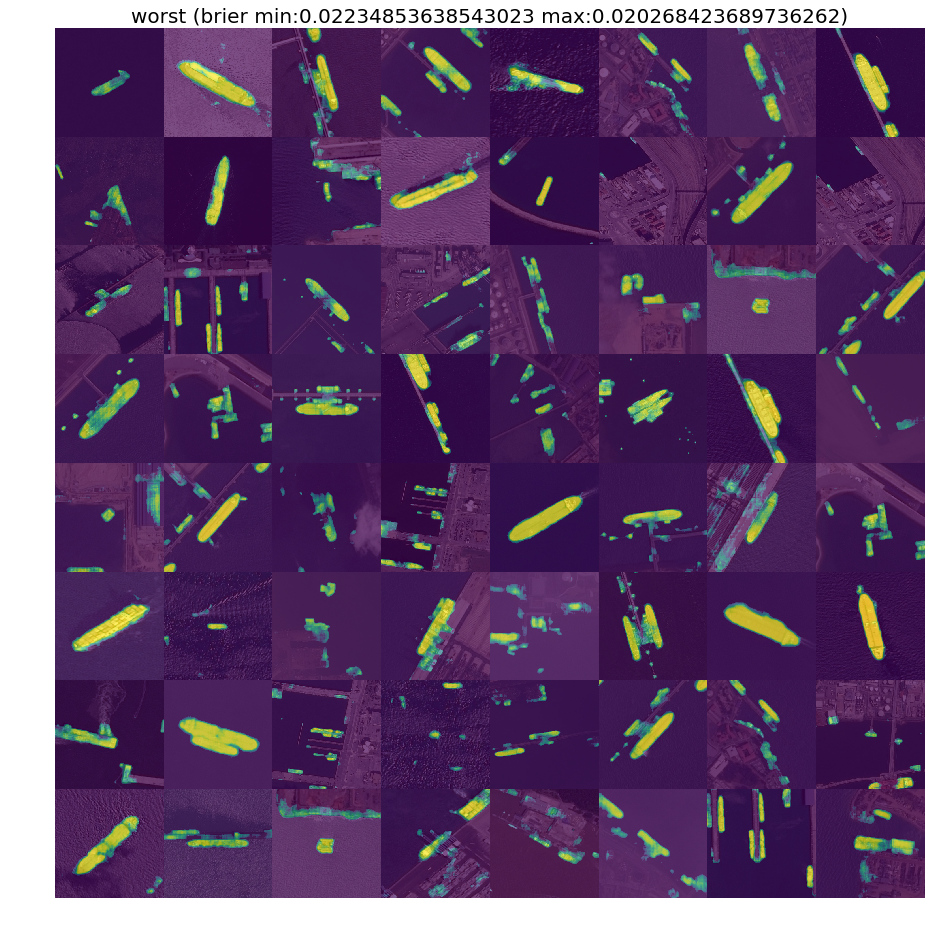

In [20]:
samples_images = np.empty((BATCH_SIZE, CROP_SIZE, CROP_SIZE, 3), dtype=np.float32)
samples_pseudo = np.empty((BATCH_SIZE, CROP_SIZE, CROP_SIZE, 1), dtype=np.float32)
score_str = 'worst'

for i, c_img_id in enumerate(best_worst[score_str]):
    c_file = os.path.join(train_img_path, c_img_id)
    c_img = cv2.cvtColor(cv2.imread(c_file), cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    c_seg = seg_model.predict(c_img[None, ...])
    samples_images[i] = c_img
    samples_pseudo[i] = c_seg[0]
#     samples_bboxes[i] = masks_to_bounding_boxes(c_seg)

batch_rgb = montage_rgb(samples_images)
batch_seg = montage(samples_pseudo[..., 0])
print(samples_images.shape)
print(batch_rgb.shape, batch_rgb.dtype)
print(batch_seg.shape, batch_seg.dtype)

fig, ax = plt.subplots(1, 1, figsize = (16, 16))
ax.imshow(batch_rgb, vmin=0, vmax=1)
ax.imshow(batch_seg, vmin=0, vmax=1, alpha=0.7)
minmax_score = best_worst_minmax_score[score_str]
ax.set_title(f'{score_str} (brier min:{minmax_score[0]} max:{minmax_score[-1]})')
plt.axis('off')
plt.savefig(os.path.join('out', BASE_MODEL, f"{train_meta_filebase}_{score_str}_batch_{BATCH_NUM}.jpg"))
plt.show()

In [ ]:
# a ship shipping ship shipping shipping ships
'0cb7e5f79_1.jpg'

['898f6f413.jpg' '534802508.jpg' '9a41bc707.jpg' '3246a992f.jpg'
 '50a951b71.jpg' '7231c33fe.jpg' '2d0809837.jpg' '936396c70.jpg']
2 uint8 (768, 768, 1) 0.000497656
1/1 [==============================] - 0s 81ms/step
2 uint8 (768, 768, 1) 0.00044952022
1/1 [==============================] - 0s 77ms/step
2 uint8 (768, 768, 1) 0.00044904568
1/1 [==============================] - 0s 83ms/step
2 uint8 (768, 768, 1) 0.00044527894
1/1 [==============================] - 0s 87ms/step
2 uint8 (768, 768, 1) 0.00043978967
1/1 [==============================] - 0s 82ms/step
2 uint8 (768, 768, 1) 0.00043548303
1/1 [==============================] - 0s 88ms/step
2 uint8 (768, 768, 1) 0.00042904436
1/1 [==============================] - 0s 83ms/step
2 uint8 (768, 768, 1) 0.0004271888
1/1 [==============================] - 0s 86ms/step


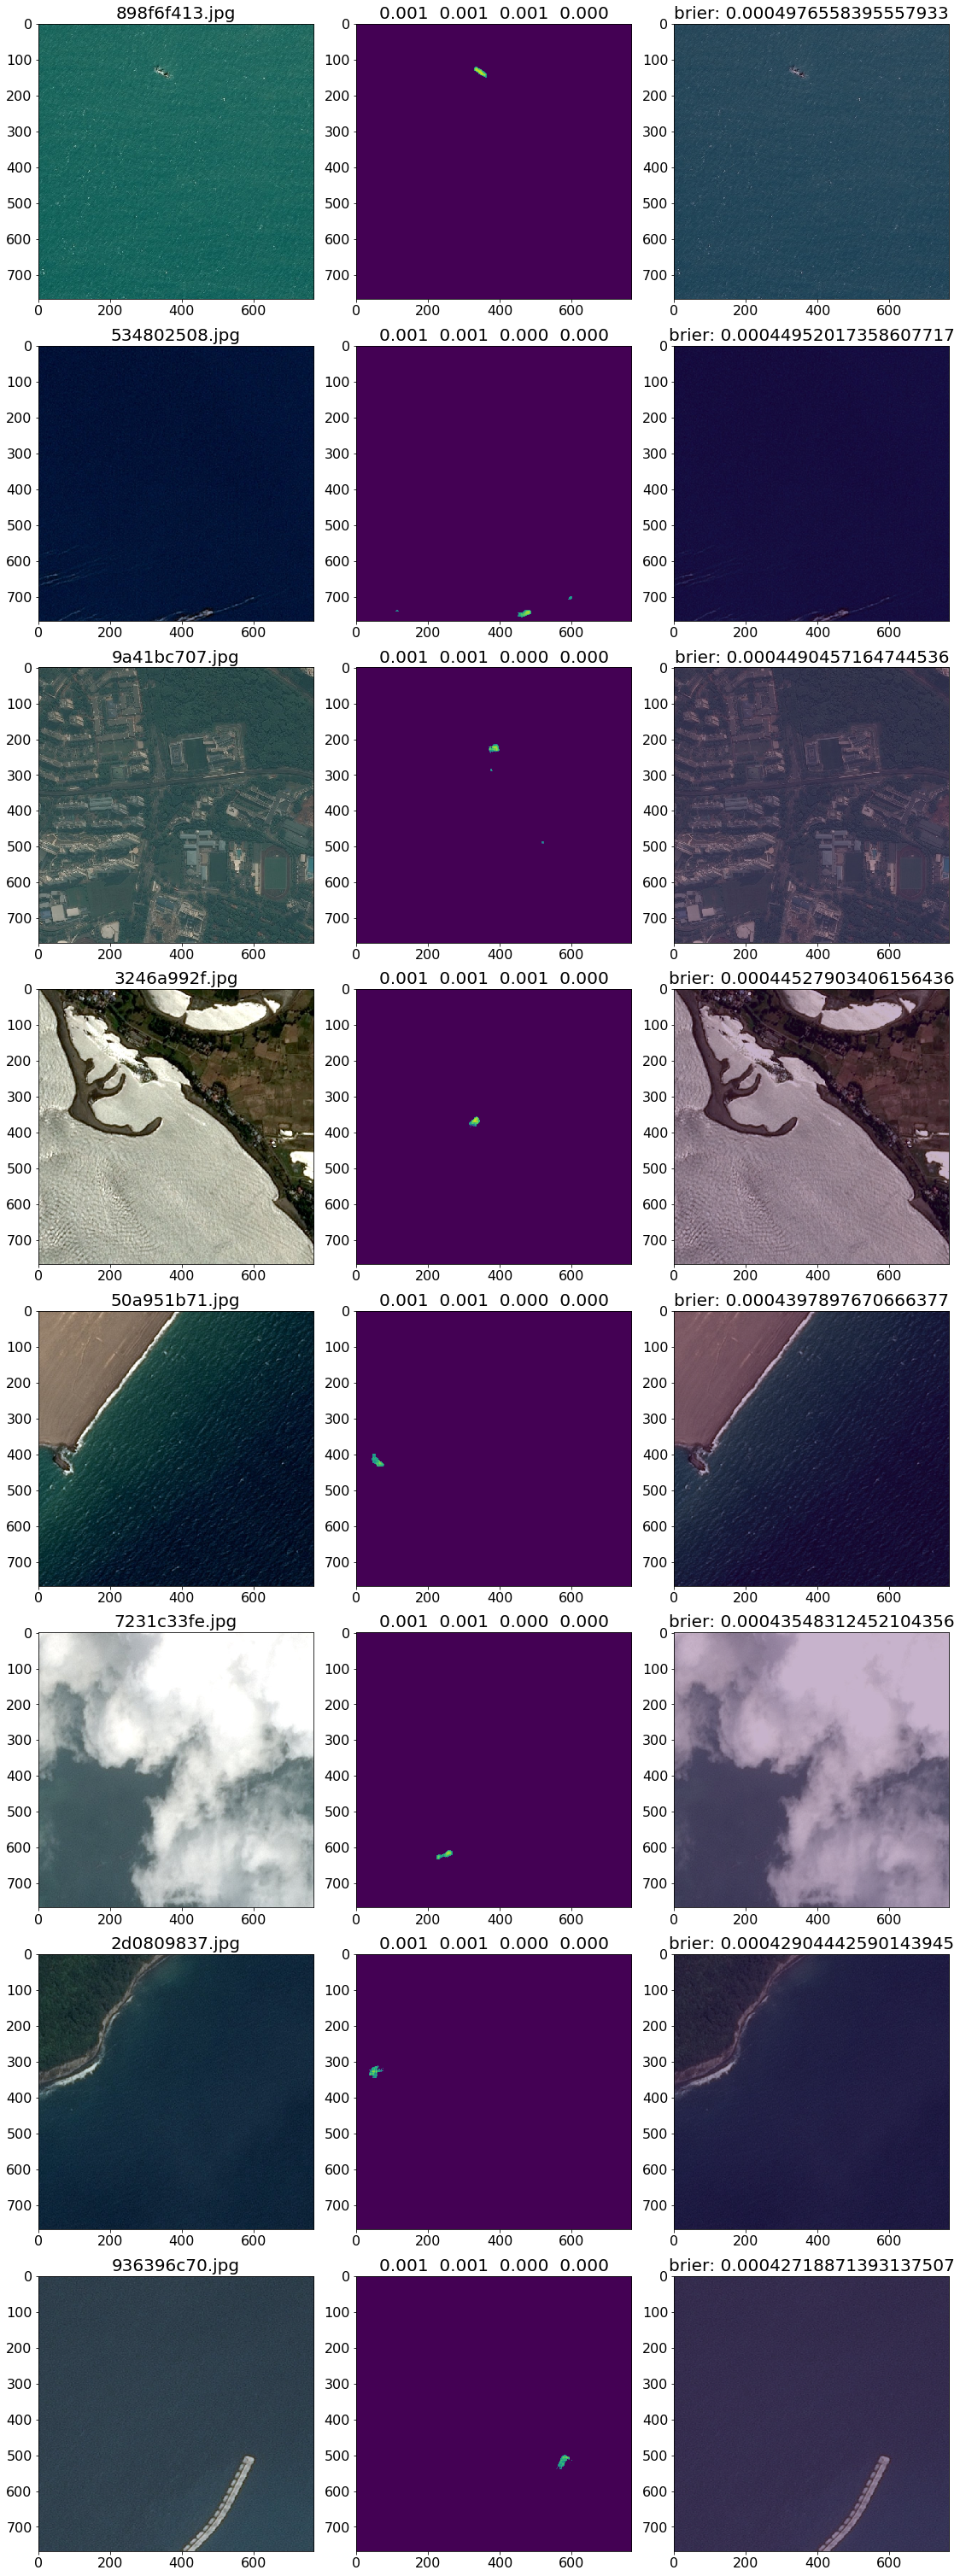

In [44]:
n_samples = 8
aa = 1

# test_files = best[aa * n_samples: (aa + 1) * n_samples]
test_files = worst[aa * n_samples: (aa + 1) * n_samples]#[::-1]
print(test_files)

fig, m_axs = plt.subplots(n_samples, 3, figsize = (16, 42))
with h5py.File(train_seg_file, 'r') as mask_1:
    for (ax1, ax2, ax4), c_img_id in zip(m_axs, test_files):
        c_file = os.path.join(train_img_path, c_img_id)
        c_img = cv2.cvtColor(cv2.imread(c_file), cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        c_seg = seg_model.predict(c_img[None, ...])
        cur_seg = binary_opening(c_seg[0] > 0.5, np.expand_dims(disk(2), -1))
        cur_rles = multi_rle_encode(cur_seg)
        try:
            y_true = mask_1[c_img_id][:] * 1
            print('1', y_true.dtype, y_true.shape, brier_loss(y_true, c_seg))
        except KeyError:
            y_true = np.zeros((IMG_SIZE, IMG_SIZE, 1), dtype=np.uint8)
            print('2', y_true.dtype, y_true.shape, brier_loss(y_true, c_seg))
        score = seg_model.evaluate(c_img[None, ...], y_true[None, ...])
        
        ax1.imshow(c_img)
        ax1.set_title(c_img_id)
        ax2.imshow(c_seg[0, :, :, 0], vmin = 0, vmax = 1)
        ax2.set_title('  '.join(map(lambda x: f"{x:.3f}", score)))
#         ax3.imshow(cur_seg[..., 0], vmin = 0, vmax = 1)
#         ax3.set_title(f'Pred: {len(cur_rles)}')# {loss_dict[c_img_id]}')
#         ax3.imshow(y_true[..., -1], vmin = 0, vmax = 1)
#         ax3.set_title(f"Truth: ") #"{image_weights.loc[image_weights['ImageId'] == c_img_id, 'counts'].values[0]}")
        ax4.imshow(c_img)
        ax4.imshow(y_true[..., -1], vmin = 0, vmax = 1, alpha=0.3)
#         ax4.imshow(c_seg[0, :, :, 0], vmin = 0, vmax = 1, alpha=0.3)
        ax4.set_title(f'brier: {loss_dict[c_img_id]}')

plt.tight_layout()
fig.savefig(os.path.join('out', BASE_MODEL, f"{train_meta_filebase}_{score_str}_batch_{BATCH_NUM}_row_{aa+1}.jpg"))

In [223]:
def predictions_to_bounding_boxes(labeled_mask):
    if labeled_mask.max() == 0:
        return labeled_mask
    else:
        img_box = np.zeros_like(labeled_mask)
        for label_id in range(1, labeled_mask.max() + 1, 1):
            label = np.where(labeled_mask == label_id, 1, 0).astype(np.uint8)
            
            _, cnt, hierarchy = cv2.findContours(label, 1, 2)
            for c, h in zip(cnt, hierarchy[0]):
                rect = cv2.minAreaRect(c)
                box = cv2.boxPoints(rect)
                box = np.int0(box)
#                 print(c.shape, box.shape)
                ret = cv2.matchShapes(c, box, 1, 0.0)
                print(ret)
                cv2.drawContours(img_box, [box], 0, label_id, -1)
#                 im2, contours, hierarchy = cv2.findContours(thresh,2,1)
#                 cnt1 = contours[0]
#                 im2, contours, hierarchy = cv2.findContours(thresh2,2,1)
#                 cnt2 = contours[0]

    
            print(img_box.sum())
        return img_box

#### [Next, Previous, First_Child, Parent]

0.1461356211937591
0.12689970962445046
0.0
0.1852715201465625
4760
0.0
0.0
0.4426386051137015
0.209296505806973
26730
0.282100005576867
43419


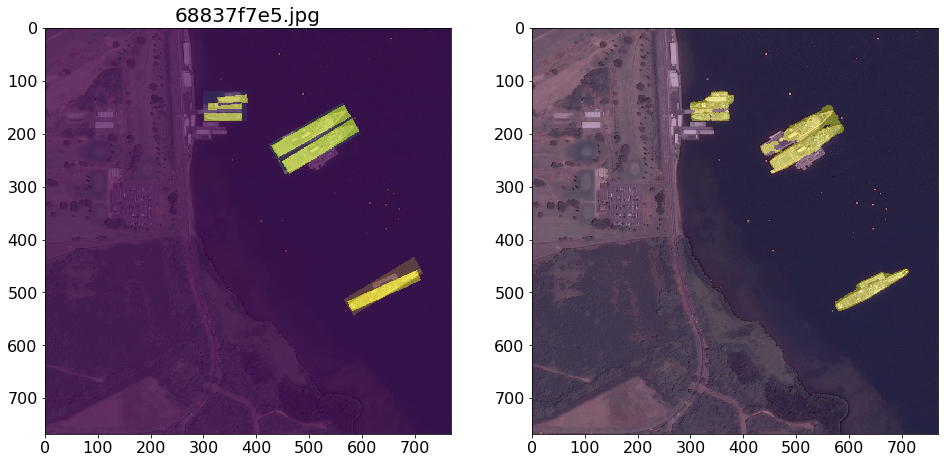

In [224]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 10))

labeled_mask, lbl_cnt = ndi.label(cur_seg)
# print(labeled_mask.shape, lbl_cnt, labeled_mask.min(), labeled_mask.max())
img_box = predictions_to_bounding_boxes(labeled_mask)
# print(img_box.shape, img_box.min(), img_box.max())
ax1.imshow(c_img)
ax1.imshow(img_box[..., 0], alpha=0.4)
ax1.imshow(y_true[..., -1], vmin = 0, vmax = 1, alpha=0.5)
# ax1.imshow(labeled_mask[..., 0], alpha=0.4)
ax1.set_title(c_img_id)
ax2.imshow(c_img)
ax2.imshow(cur_seg[..., 0], alpha=0.4)
# ax2.imshow(c_seg[0, :, :, 0], vmin = 0, vmax = 1, alpha=0.4)
# ax2.set_title('  '.join(map(lambda x: f"{x:.3f}", score)))

plt.show()